In [1]:
import sys
sys.path.append("../../")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.utils.sampling import draw_sobol_samples

from optimizers.lfbo.lfbo_rff import LFBO_RFF
from optimizers.utils import split_good_bad

tkwargs = {"device": "cpu:0", "dtype": torch.double}

In [3]:
def forrester(x, noise_level=.2):
    f = np.sin(3*x) + x**2 - 0.7*x + np.random.normal(0, noise_level, x.shape)
    return f
bounds = torch.tensor([[-1.], [2.]], **tkwargs)
gamma = 1/2

In [4]:
x_dense = torch.linspace(-1, 2, 512, **tkwargs).reshape(-1, 1)
y_dense = forrester(x_dense, noise_level=0)

In [5]:
num_obs = 100
x_obs = draw_sobol_samples(bounds=bounds, n=num_obs, q=1, seed=123).squeeze(-2)
y_obs = forrester(x_obs, noise_level=0.2)

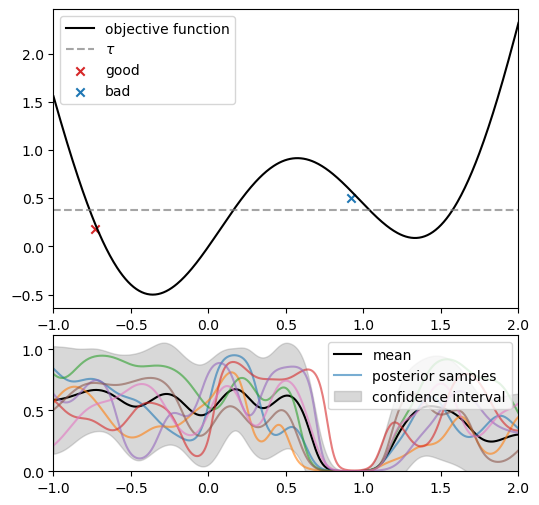

In [8]:
num_iter = 1
obs_start = 2
step = 1

for i in range(num_iter):
    lfbo = LFBO_RFF(input_dim=1, output_dim=1, dropout_rate=0.0)
    lfbo.fit(x_obs[:obs_start+i*step], y_obs[:obs_start+i*step], gamma=gamma, S=500)
    acf_mean, acf_samples = lfbo.predict(x_dense)
    # acf_mean = acf_mean / (1 - acf_mean)
    # acf_samples = acf_samples / (1 - acf_samples)
    acf_std = torch.std(acf_samples, axis=0)
    
    fig = plt.figure(figsize=(6, 6))

    ax_func = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax_func.plot(x_dense, y_dense, color='k', label="objective function")
    tau = np.quantile(y_obs, q=gamma)
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x, y, z = split_good_bad(x_obs[:obs_start+i*step], y_obs[:obs_start+i*step], gamma=1/3)
    z = z.bool()
    ax_func.scatter(x[z], y[z], marker='x', color='tab:red', label="good")
    ax_func.scatter(x[~z], y[~z], marker='x', color='tab:blue', label="bad")
    ax_func.set_xlim(-1., 2.)
    ax_func.legend();

    ax_lfbo = plt.subplot2grid((3, 1), (2, 0), rowspan=1, sharex=ax_func)
    ax_lfbo.plot(
        x_dense,
        acf_mean.reshape(x_dense.shape),
        c='k',
        label="mean",
    )
    for n, posterior_sample in enumerate(acf_samples):
        ax_lfbo.plot(
            x_dense,
            posterior_sample.reshape(x_dense.shape),
            alpha=.6,
            label='posterior samples' if n<1 else None
        )
        if n > 5:
            break

    ax_lfbo.fill_between(
        x_dense.flatten(),
        (acf_mean+2*acf_std).ravel(),
        (acf_mean-2*acf_std).ravel(),
        color="tab:gray",
        alpha=0.3,
        label="confidence interval",
    )
    
    # ax_lfbo.set_ylim(0., 1.2)
    ax_lfbo.set_ylim(0., None)
    ax_lfbo.legend()
    plt.show()